In [1]:
import torch
torch.__version__
from torch.nn import Linear
import pandas as pd

In [2]:

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 KB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 10.8 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=6045f5b32fa6f9d84932b28c57a356a0f2068e01d1e1c91ad70919fc534f714b
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  

In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec


dataset = Planetoid(root='./', name='Cora')
data = dataset[0]
device = torch.device('cuda')

Processing...
Done!


In [4]:
#p,q表示BFS,DFS的不同采样概率
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                     context_size=10, walks_per_node=10,
                     num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

Epoch: 10, Loss: 1.7562, Acc: 0.4250
Epoch: 20, Loss: 0.9746, Acc: 0.6230
Epoch: 30, Loss: 0.8728, Acc: 0.6810
Epoch: 40, Loss: 0.8449, Acc: 0.6910
Epoch: 50, Loss: 0.8354, Acc: 0.7030
Epoch: 60, Loss: 0.8306, Acc: 0.6970
Epoch: 70, Loss: 0.8268, Acc: 0.7060
Epoch: 80, Loss: 0.8262, Acc: 0.7040
Epoch: 90, Loss: 0.8249, Acc: 0.6950
Epoch: 100, Loss: 0.8255, Acc: 0.7110
Epoch: 110, Loss: 0.8252, Acc: 0.7130
Epoch: 120, Loss: 0.8240, Acc: 0.6930
Epoch: 130, Loss: 0.8246, Acc: 0.7030
Epoch: 140, Loss: 0.8244, Acc: 0.7090
Epoch: 150, Loss: 0.8240, Acc: 0.6900
Epoch: 160, Loss: 0.8244, Acc: 0.7130
Epoch: 170, Loss: 0.8241, Acc: 0.7000
Epoch: 180, Loss: 0.8235, Acc: 0.7150
Epoch: 190, Loss: 0.8242, Acc: 0.7120
Epoch: 200, Loss: 0.8242, Acc: 0.7220
best acc in test: 0.73 ,Epoch: 161


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


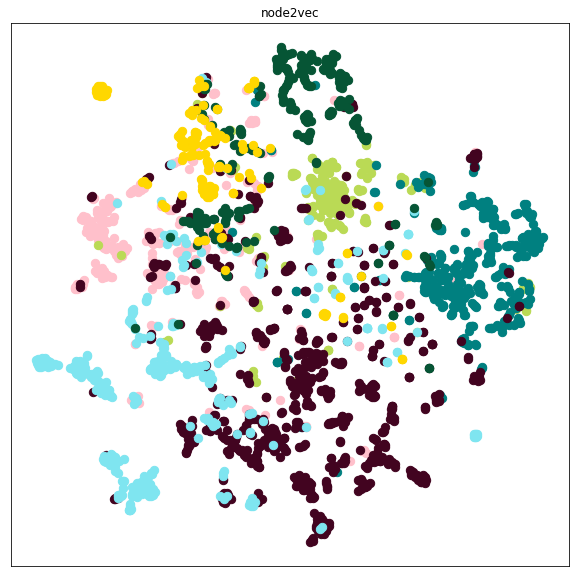

In [5]:
def train():
    model.train()
    total_loss = 0
    #使用torch Embedding 对随机游走的结果做嵌入，采用逻辑斯特回归做分类

    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        #loss 正负随机游走的embedding的损失之和，希望正样例之间的对数似然更大，负样例之间的更小
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                         z[data.test_mask], data.y[data.test_mask],
                        #  atype = 'Forest',
                         max_iter=100)
    return acc

accL=[]
for epoch in range(200):
    loss = train()
    acc = test()
    accL.append(acc)
    if (epoch+1)%10==0:
        print(f'Epoch: {epoch+1:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')
print('best acc in test:',max(accL),',Epoch:',accL.index(max(accL)))

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    #可视化聚类结果
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=70, color=colors[i], cmap="Set2")
    # plt.axis('off')
    plt.title("node2vec")
    plt.savefig("./node2vec.png",dpi=600)
    plt.show()
        

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)